<a href="https://colab.research.google.com/github/dudechego/My-ML-Projects/blob/main/Deep%20Learning%20Projects/FashionMNIST_Model_Classifaction_Pytorch_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#Look at our data
train_data = FashionMNIST(
root="data", train=True,
transform=transforms.ToTensor(),
download=True)

test_data = FashionMNIST(
root="data", train=False,
transform=transforms.ToTensor(),
download=True)

len(train_data), len(test_data)

(60000, 10000)

In [ ]:
#Explore our Data
#train_data[0]
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

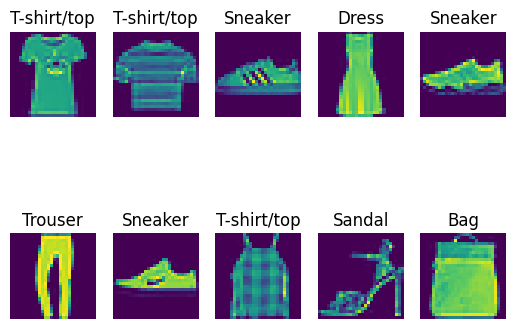

In [ ]:
#Plot our data
nrows=2
ncols=5
fig, ax = plt.subplots(nrows, ncols,) #figsize=(20,18))

for row in range(nrows):
    for col in range(ncols):
        random_idx = torch.randint(0, len(train_data), size=(1,)).item()
        image, title = train_data[random_idx]
        image = image.permute(1,2,0).squeeze()

        ax[row, col].imshow(image)
        ax[row, col].set_title(class_names[title])
        ax[row, col].axis(False)
        ax[row, col].grid(True)
plt.show()

In [ ]:
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
random_idx

26463

In [ ]:
len(class_names)

10

In [ ]:
train_data[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 4

In [ ]:
##Create DataLoaders
train_dataloader = DataLoader(
train_data, batch_size=BATCH_SIZE,
num_workers=1, shuffle=True)

test_dataloader = DataLoader(
test_data, batch_size=BATCH_SIZE,
num_workers=1, shuffle=True)

In [ ]:
##Create Model
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 14, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(14, 28, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()

        self.linear = nn.Linear((28*7*7), 28)
        self.output = nn.Linear(28, len(class_names))

    def forward(self, x):
        x = self.conv1(x) #(14, 14, 14)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv2(x) #(28, 7, 7)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        return x

model = FashionMNISTModel().to(device)
model

FashionMNISTModel(
  (conv1): Conv2d(1, 14, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(14, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=1372, out_features=28, bias=True)
  (output): Linear(in_features=28, out_features=10, bias=True)
)

In [ ]:
#Create Accuracy Function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
#Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
model.parameters(), lr=LR)

In [ ]:
#Train and Test Step
from tqdm.auto import tqdm

torch.manual_seed(2)
torch.cuda.manual_seed(2)

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    train_accuracy = 0

    for batch, (input, labels) in enumerate(train_dataloader):
        model.train()

        input, labels = input.to(device), labels.to(device)

        y_logits = model(input)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

        loss = loss_fn(y_logits, labels)
        acc = accuracy_fn(labels, y_preds)

        train_accuracy += acc
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Test Step
    test_loss = 0
    test_accuracy = 0
    for batch, (X, y) in enumerate(test_dataloader):
        model.eval()
        X, y = X.to(device), y.to(device)


        with torch.inference_mode():
            test_logits = model(X)
            #print(test_logits)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

            loss_test = loss_fn(test_logits, y)
            test_acc = accuracy_fn(y, test_preds)

            test_accuracy += test_acc
            test_loss += loss_test.item()

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataloader)
    test_loss = test_loss / len(test_dataloader)
    test_accuracy = test_accuracy / len(test_dataloader)

    #Print Out What's Happening
    print(f""" Epoch: {epoch} |
          Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, |
          Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}, |
    """)

  0%|          | 0/4 [00:00<?, ?it/s]

 Epoch: 0 | 
          Train Loss: 0.4864, Train Accuracy: 82.50, | 
          Test Loss: 0.3854, Test Accuracy: 86.60, | 
    
 Epoch: 1 | 
          Train Loss: 0.3332, Train Accuracy: 88.02, | 
          Test Loss: 0.3365, Test Accuracy: 88.08, | 
    
 Epoch: 2 | 
          Train Loss: 0.2931, Train Accuracy: 89.37, | 
          Test Loss: 0.3166, Test Accuracy: 88.47, | 
    
 Epoch: 3 | 
          Train Loss: 0.2681, Train Accuracy: 90.29, | 
          Test Loss: 0.2877, Test Accuracy: 89.60, | 
    


In [ ]:

for batch, (X, y) in enumerate(test_dataloader):
    model.eval()
    X, y = X.to(device), y.to(device)
    with torch.inference_mode():
        test_logits = model(X)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        loss_test = loss_fn(test_logits, y)
        test_acc = accuracy_fn(y, test_preds)

        test_accuracy += test_acc
        test_loss += loss_test.item()

In [ ]:
##Make Predictions
#my_image =
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
image, title = train_data[random_idx]
#image = image.permute(1,2,0).squeeze()
title = class_names[title]
print(title)

Ankle boot


In [ ]:
#image = image.reshape(1, -1)

In [ ]:
model.eval()
with torch.inference_mode():
    image = image.to(device)
    # Add a batch dimension to the image
    image = image.unsqueeze(0)
    logit = model(image)
    prediction = torch.softmax(logit, dim=1).argmax()


    title_pred = class_names[prediction]
    print(title_pred)

Ankle boot
